# Tentativa de amarração de poço utilizando apenas o perfil de Resistividade

Utilizamos o poço 2-BGST-1-MA e a linha X da Bacia do Parnaíba. Corrigimos com o checkshot extraído do poço 1-FL-1-PI.

In [1]:
import numpy as np
from matplotlib import pylab
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
%matplotlib inline

In [2]:
cd "G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\2-BGST-1-MA"

G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\2-BGST-1-MA


In [3]:
data = np.loadtxt('Dados_amarrando.csv', delimiter=';')

**(0)Profundidade_DM (1)Resistividade (2)Fator_Formação (3)Vagarosidade/Sônico (4)Densidade (5)Impedância**

In [4]:
data = np.loadtxt('Dados_amarrando.csv', delimiter=';')
vel_corrigida = np.loadtxt('sonico_corrigido', delimiter=';')

In [5]:
profundidade = data[:,0]
resistividade = data[:,1]
velocidade = vel_corrigida [ vel_corrigida > 2000 ]
densidade = 1.75*(1/velocidade**0.3)
impedancia = velocidade*densidade

## Funções

#### Função para criar o vetor tempo duplo a partir dos dados de profundidade e velocidade

In [6]:
def transf_prof_tempo(profundidade, velocidade):
    """
    Retorna um array de tempo, a partir dos arrays de
    profundidades e velocidades (Sônico) dos dados de poço
    
    *profundidade : array
        Dados de poço de profundidade
    *velocidade : array
        Dados do perfil sônico do poço (1/vagarosidades) - em km
    *tempo : array
        Retorna o tempo calculado
    
    """
    
    #Transformando Profundidade em Tempo
    dx=(profundidade[1:] - profundidade[:-1])
    dt=(dx*0.001)/velocidade[:-1]
    
    #VETOR TEMPO
    tempo = np.zeros(dt.size+1)
    
    tempo[0] = 0
    soma = dt[0]
    for i in range(1, dt.size+1):
        soma += dt[i-1]
        tempo[i] = soma
    tempo*=2
    
    return tempo

#### !!!Função para encontrar um *tempo específico* dada uma *profundidade específica*!!!

Primeiramente, esta função **compara o valor fornecido de profundidade (md_depth) com cada valor do array original de profundidades**. Se algum destes for **igual** ao de profundidade (md_depth), a função **retorna o valor do array original de tempo** que estiver localizado **na mesma posição** em que está o **valor de profundidade, no array de profundidade**. (assumindo que estes têm o **mesmo tamanho**)

**Se não** for encontrado valor exatamente igual, esta função utiliza duas comparações simultâneas para encontrar **um valor logo abaixo e um logo acima** ao valor fornecido de profundidade (md_depth):
+ Compara o valor fornecido de profundidade (md_depth) **com** cada um dos valores do array de profundidade
+ Compara a diferença entre valor fornecido de profundidade (md_depth) e cada um dos valores de profundidade **com** a diferença de cada dois valores de profundidade entre si (no caso, 0.2).

Após esta comparação, a função calcula uma **regressão linear** entre os pontos logo acima e logo abaixo do valor fornecido de profundidade (md_depth), para encontrar o valor de tempo referente.

In [7]:
def interpx(x, xs, ys):
    """interpolat at x the function 
    defined by xs and ys"""
    ##    

In [8]:
def depth_time(md_depth, time, depth):
    """
    Retorna o valor em TWT correspondente a md_depth a partir da
    relação tempo profundidade definida por :
    
    * md_depth : float
        profundidade que se deseja descobrir tempo referente
    * tempo : array
        dados de tempo em segundos (TWT - Two Way Time)
    * profundidade : array
        dados de profundidade metros (MD - Mesured Depth) - mesmo tamanho do tempo
    * twt_time : float
        tempo que será retornado (referente à profundidade de entrada)
        
    """
    
    for i in range(len(depth)):
        if md_depth == depth[i]:
            return time[i]            
        else: # Encontrando x1, x2, y1, y2
            if md_depth > depth[i] and md_depth - depth[i] < np.diff(depth)[i]:
                x1=depth[i]
                y1=time[i]
            if md_depth < depth[i] and abs(md_depth - depth[i]) < np.diff(depth)[i]:
                x2=depth[i]
                y2=time[i]
    
    #Calculando coeficientes
    x0 = md_depth
    a = (y2 - y1)/(x2 - x1)
    b = y1 - a*x1
    y0 = a*x0 + b
    twt_time = y0
    
    return twt_time

#### Função de Reamostragem

In [9]:
def reamostra(taxa, x, y):
    """
    Interpola e reamostra um array para uma taxa de amostragem específica.
    
    *taxa : float
        taxa de amostragem final
    *x : array
        "eixo x" da reamostragem
    *y : array
        "eixo y" da reamostragem (impedância)
    *resultado : array
        dado reamostrado e interpolado final
    
    """
    maxt = np.max(x)
    
    t = np.arange(0, maxt, taxa)
    resultado = np.interp(x = t, xp = x, fp = y)
    
    return t, resultado

#### Função de Filtragem
Evita o falseamento dos dados (alias)

In [10]:
def filtro(N, fcorte, taxa, data):
    """
    Filtra um array
    
    *N : integer
        ordem do filtro
    *fcorte : float (?)
        frequência de corte desejada
    *taxa : float
        taxa de amostragem do dado
    *data : array
        dados a serem filtrados
    *result: array
        output da função. Dados filtrados
    
    """
    
    Wn = fcorte/(1/(2*taxa)) # Cutoff frequency: Wn*Fnyquist=fcorte
    B, A = butter(N, Wn, output='ba') #Filtro Butterworth
    result=filtfilt(B,A,data)
    
    return result

#### Função para plotar passo-a-passo da reamostragem e filtragem

In [11]:
def plot_reamostragem(impedancia, Z_t, Z_f, Z_fr, RC, RC_t, RC_f, RC_fr, tempo, t, tfr):
    """
    Plota o passo-a-passo da reamostragem, filtragem e nova
    reamostragem da impedância e da refletividade.
    
    *impedância : array
        dados de impedância original do poço
    *Z_t : array
        impedância reamostrada para uma taxa menor que a variação mínima da impedância original
    *Z_f : array
        impedância filtrada com filtro passa-baixa
    *Z_fr : array
        impedância filtrada e reamostrada para 4ms
    *RC : array
        refletividade calculada a partir dos dados de impedância original do poço
    *RC_t : array
        refletividade reamostrada para uma taxa menor que a variação mínima da impedância original
    *RC_f : array
        refletividade filtrada com filtro passa-baixa
    *RC_fr : array
        refletividade filtrada e reamostrada para 4ms
    *tempo : array
        tempo calculado a partir dos arrays de profundidades e velocidades (Sônico) dos dados de poço
    *t : array
        tempo reamostrado para uma taxa menor que a variação mínima da impedância original
    *tfr : array
        tempo filtrado e reamostrado para 4ms
    
    """
    
    #IMPEDÂNCIA
    pylab.figure(figsize=(15,15))
    
    pylab.subplot(1,4,1)
    pylab.plot(impedancia, tempo)
    pylab.plot(impedancia, tempo, '+')
    plt.title('Impedância Original')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,2)
    pylab.plot(Z_t, t)
    pylab.plot(Z_t, t, '+')
    plt.title('Reamostragem 0.06ms')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,3)
    pylab.plot(Z_f, t)
    pylab.plot(Z_f, t, '+')
    plt.title('Filtragem Passa Baixa (100Hz)')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,4)
    pylab.plot(Z_fr, tfr)
    pylab.plot(Z_fr, tfr, '+')
    plt.title('Reamostragem 4ms')
    plt.gca().invert_yaxis()
    pylab.show()
    
    #REFLETIVIDADE
    pylab.figure(figsize=(15,15))
    
    pylab.subplot(1,4,1)
    pylab.plot(RC, tempo[:-1])
    pylab.plot(RC, tempo[:-1],'+')
    plt.title('Refletividade Original')
    plt.gca().invert_yaxis()
        
    pylab.subplot(1,4,2)
    pylab.plot(RC_t, t[:-1])
    pylab.plot(RC_t, t[:-1],'+')
    plt.title('Reamostragem 0.06ms')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,3)
    pylab.plot(RC_f, t[:-1])
    pylab.plot(RC_f, t[:-1], '+')
    plt.title('Filtragem Passa Baixa (100Hz)')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,4)
    pylab.plot(RC_fr, tfr[:-1])
    pylab.plot(RC_fr, tfr[:-1], '+')
    plt.title('Reamostragem 4ms')
    plt.gca().invert_yaxis()
    pylab.show()

#### Funções para criar a Ricker e convolvê-la com a Refletividade

In [12]:
def ricker(f, length, dt):
    """
    Criação da Wavelet Ricker
    
    *f : float
        frequência central
    *length : float
        tamanho da ricker
    *dt : float
        taxa de amostragem
    
    """
    t = np.linspace(-length / 2, (length-dt) / 2, length / dt)
    y = (1. - 2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

In [13]:
def convolucao(RC_fr):
    """
    Convolução da Refletividade com a Wavelet Ricker
    
    *RC_fr : array
        refletividade filtrada e reamostrada para 4ms
    
    """
    
    RC_fr = np.nan_to_num(RC_fr)
    tw, w = ricker (f=25, length = 0.256, dt = 0.004)
    synth = np.convolve(w, RC_fr, mode='same')
    
    return synth
    

#### Função para plot conjugado com sintético e marcações das soleiras

In [14]:
def plot_synth_sill(resistividade, tempo, Z_fr, RC_fr, synth, tfr, soleiras):
    """
    Plot conjugado da Resistividade, Impedância, Refletividade e
    do Sintético, com as marcações das soleiras
    
    *resistividade : array
        dados de resistividade original do poço
    *tempo : array
        tempo calculado a partir dos arrays de profundidades e velocidades (Sônico) dos dados de poço
    *Z_fr : array
        impedância filtrada e reamostrada para 4ms
    *RC_fr : array
        refletividade filtrada e reamostrada para 4ms
    *synth : array
        sintético criado a partir da convolução da refletividade com a Waveler Ricker
    *tfr : array
        tempo filtrado e reamostrado para 4ms
    *soleiras : array
        EXPLICAR
    
    """
      
    pylab.figure(figsize=(15,15))
    
    pylab.subplot(1,4,1)
    pylab.plot(resistividade, tempo, c='k', lw=1)
    plt.title('resist X tempo')
    for i in range(len(soleiras)):
        plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,2)
    pylab.plot(Z_fr, tfr, c='k', lw=1)
    plt.title('imped X tempo')
    for i in range(len(soleiras)):
        plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,3)
    pylab.hlines(tfr[:-1], 0, RC_fr, lw=1) #refletividade em barrinhas
    pylab.plot([0, 0], [tfr.min(), tfr.max()], c='k', alpha = 1, lw=1) #middle bar
    plt.title('reflet X tempo')
    for i in range(len(soleiras)):
        plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,4)
    pylab.plot(synth, tfr[:-1], c='k')
    #pylab.fill_between(synth, tfr[:-1]*2, 0,  synth > 0.0,  color='k', alpha = 1.0)
    plt.title('sintético X tempo')
    for i in range(len(soleiras)):
        plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
    plt.gca().invert_yaxis()
    
    pylab.show()

## Código principal

### Impedance from resistiviy - Gardner and Faust
_O Cálculo para sair da resistividade e chegar a impedância foi feito usando as relações de gardner e Faust, no EXCEL_

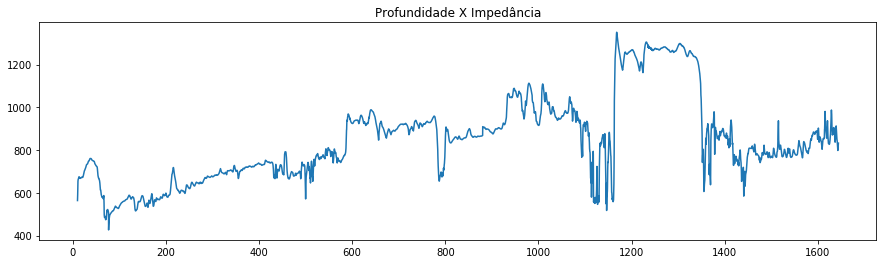

In [15]:
pylab.figure(figsize=(15,4))
pylab.plot(profundidade[2:], impedancia)
plt.title('Profundidade X Impedância')
pylab.show()

### Reflectivity 

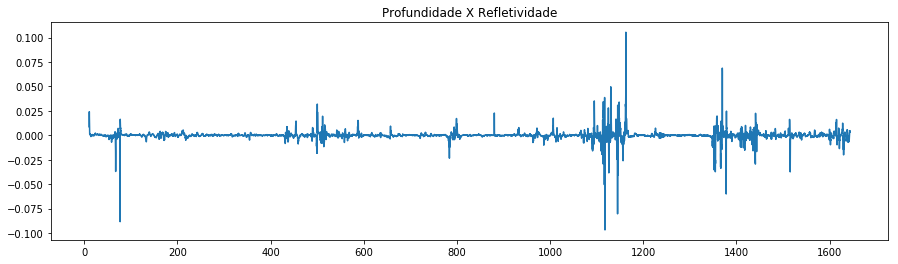

In [16]:
#Cálculo da Refletividade

RC = (impedancia[1:] - impedancia[:-1]) / (impedancia[1:] + impedancia[:-1])

pylab.figure(figsize=(15,4))
pylab.plot(profundidade[3:], RC)
plt.title('Profundidade X Refletividade')
pylab.show()

### Relação Tempo x Profundidade

**Visualizando a Velocidade X Tempo**

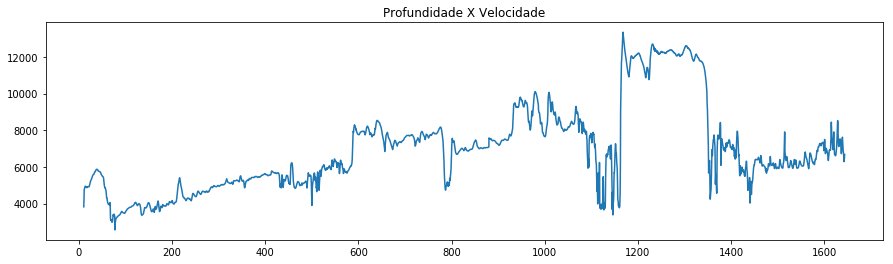

In [17]:
pylab.figure(figsize=(15,4))
pylab.plot(profundidade[2:], velocidade)
plt.title('Profundidade X Velocidade')
pylab.show()

**Transformando a escala de profundidade em tempo com a função "transf_prof_tempo"**  
Criando o primeiro vetor de tempo duplo

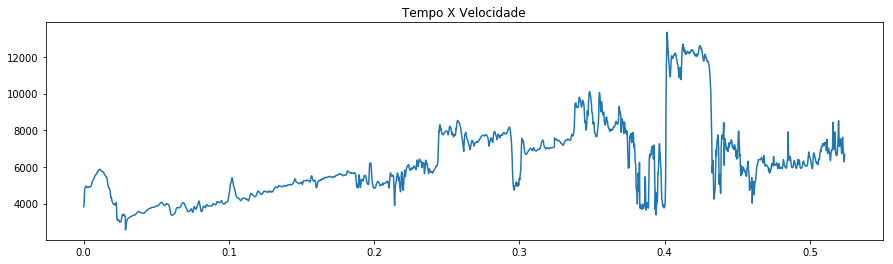

In [18]:
tempo = transf_prof_tempo(profundidade[2:],velocidade)*1000

pylab.figure(figsize=(15,4))
pylab.plot(tempo, velocidade)
plt.title('Tempo X Velocidade')
pylab.show()

### Filtragem e Reamostragem para 4ms
Avaliando a amostragem do **tempo original** (Calculado a partir da relação entre profundidade e velocidade), percebemos que **não existe uma taxa contínua**. Por isso, usamos uma taxa que fosse **menor do que a varíação mínima** entre amostras do tempo original para fazer uma primeira reamostragem. O valor utilizado foi de **0.06ms**. Em seguida, fizemos uma **filtragem** para **cortar altas frequências e evitar falseamento do dado**, e por fim reamostramos este dado **filtrado para 4ms**, para coincidir com a sísmica que escolhemos para amarrar.

In [19]:
np.diff(tempo) #Avaliando a taxa de amostragem do tempo original

array([  2.09069589e-04,   1.01934794e-04,   9.76547943e-05, ...,
         6.19747943e-05,   6.13347943e-05,   6.04947943e-05])

In [20]:
np.min(np.diff(tempo)) #Variação mínima do tempo original. Usar na primeira reamostragem.

2.997479431315897e-05

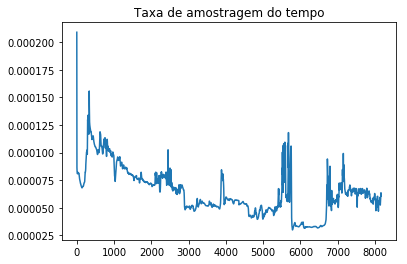

In [21]:
pylab.plot(np.diff(tempo))
plt.title('Taxa de amostragem do tempo')
pylab.show()

**Reamostragem(0.06ms) - Filtragem(100Hz) - Reamostragem(4ms)**

**impedância**: dados de impedância **original** do poço  
**Z_t**: **i**mpedância **r**eamostrada para uma taxa menor que a variação mínima da impedância original  
**Z_f**: **i**mpedância **f**iltrada com filtro passa-baixa  
**Z_fr**: **i**mpedância **f**iltrada e **r**eamostrada para 4ms  
**RC**: **r**efletividade calculada a partir dos dados de impedância original do poço  
**RC_t**: **r**efletividade **r**eamostrada para uma taxa menor que a variação mínima da impedância original  
**RC_f**: **r**efletividade **f**iltrada com filtro passa-baixa  
**RC_fr**: **r**efletividade **f**iltrada e **r**eamostrada para 4ms  
**tempo**: tempo **calculado** a partir dos arrays de profundidades e velocidades (Sônico) dos dados de poço  
**t**: **t**empo **r**eamostrado para uma taxa menor que a variação mínima da impedância original  
**tfr**: **t**empo **f**iltrado e **r**eamostrado para 4ms  

In [22]:
#-------------------REAMOSTRANDO O TEMPO (com a menor variação de tempo)----------------------#

taxa = 0.00006 #menor que a variação mínima do tempo original
(t, Z_t) = reamostra(taxa, tempo, impedancia)
RC_t = (Z_t[1:] - Z_t[:-1]) / (Z_t[1:] + Z_t[:-1]) 

#-------------------FILTRO PASSA BAIXA----------------------#

N = 2    # Ordem do Filtro
fcorte=100 #Frequência de Corte

Z_f = filtro(N, fcorte, taxa, Z_t) 
RC_f = (Z_f[1:] - Z_f[:-1]) / (Z_f[1:] + Z_f[:-1]) 

#-------------------REAMOSTRANDO O TEMPO 4ms ----------------------#
taxa_r = 0.004 

(tfr, Z_fr) = reamostra(taxa_r, t, Z_f) 
RC_fr = (Z_fr[1:] - Z_fr[:-1]) / (Z_fr[1:] + Z_fr[:-1]) 

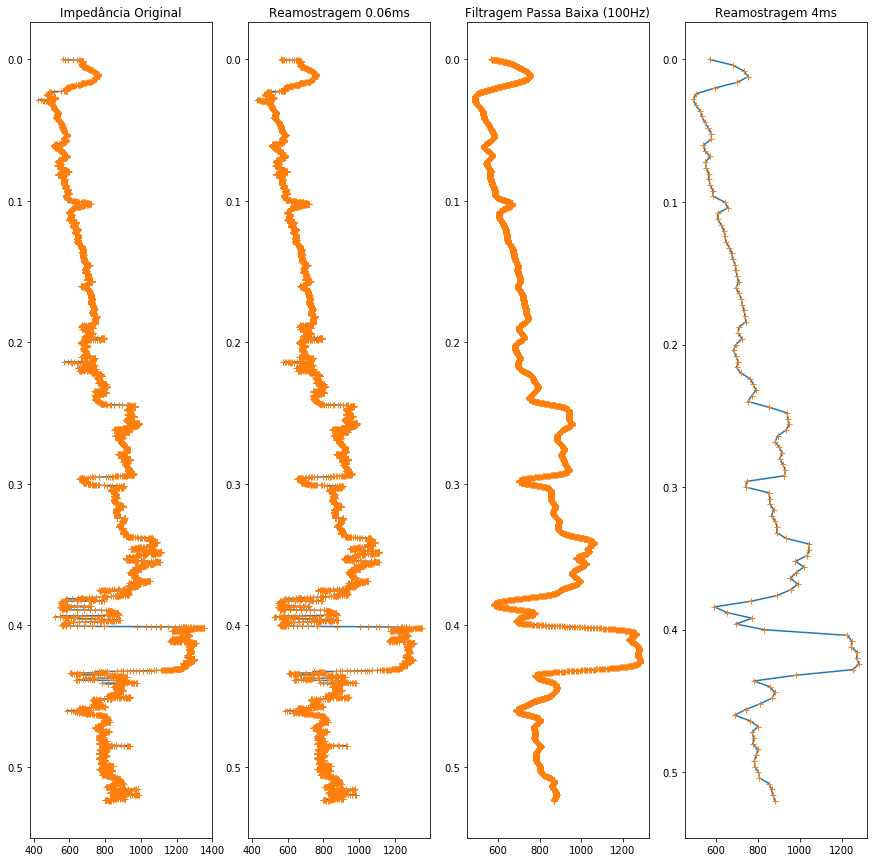

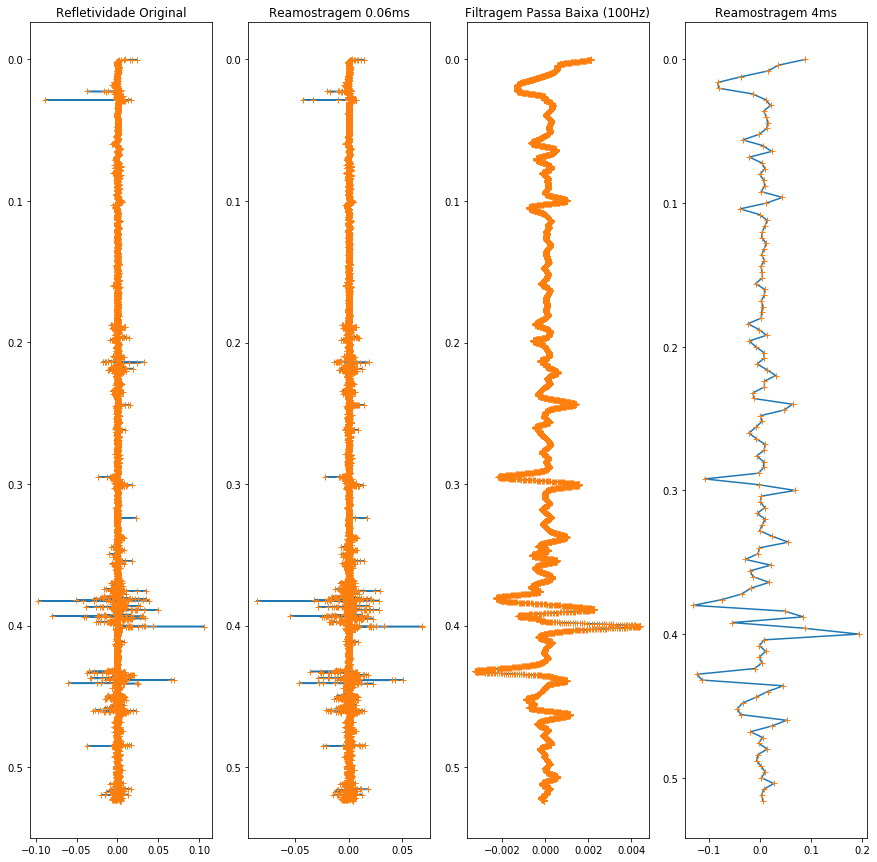

In [23]:
plot_reamostragem(impedancia, Z_t, Z_f, Z_fr, RC, RC_t, RC_f, RC_fr, tempo, t, tfr)

### Convolução

A convolução com a Ricker foi feita com uma função criada para este código, na qual você simplesmente dá o array de refletividades e recebe o perfil sintético.

In [24]:
synth = convolucao(-RC_fr)

C:\Users\rmdias\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


#### Encontrando as soleiras no tempo (função depth_time)

A partir da função depth_time, criada neste código, conseguimos descobrir o tempo referente a qualquer profundidade desejada, analisando apenas os vetores de profundidade e tempo originais. As profundidades das soleiras se encontram no pdf do perfil composto do poço. Calculamos, com isso, a posição, em tempo, das bases e topos de cada soleira.

In [25]:
s1_t = depth_time(590.0, tempo, profundidade) #topo da primeira soleira
s1_b = depth_time(785.0, tempo, profundidade) #base da primeira soleira
s2_t = depth_time(1160.0, tempo, profundidade) #topo da segunda soleira
s2_b = depth_time(1350.0, tempo, profundidade) #base da segunda soleira

soleiras=(s1_t, s1_b, s2_t, s2_b)

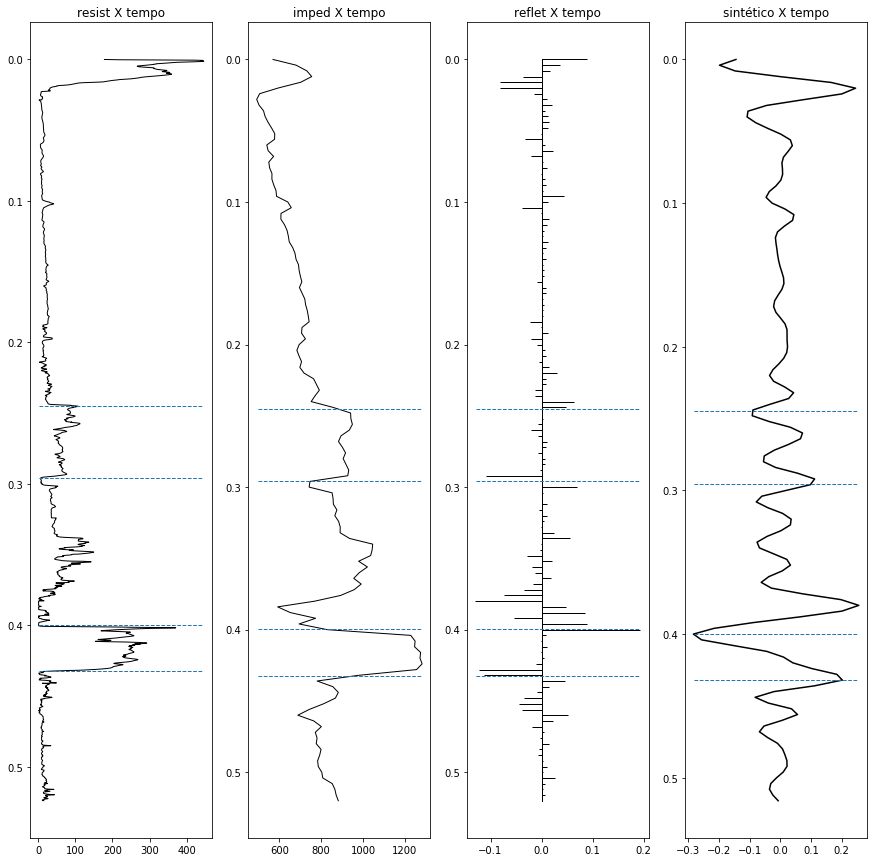

In [26]:
plot_synth_sill(resistividade[2:], tempo, Z_fr, RC_fr, synth, tfr, soleiras)

### Carregando .segy - Cimageo
Esta é a primeira linha sísmica que desejamos amarrar

In [28]:
from obspy.io.segy.segy import _read_segy

segyfile = _read_segy(r'G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\0317-0112_Cimageo\0317-0112_PSTM.sgy')
# turn ObsPy Stream in a matrix of traces
# first dimension time, second dimension traces
ntraces = len(segyfile.traces)
nsamples = len(segyfile.traces[0].data)
mtraces = np.zeros((nsamples, ntraces))
i = 0
for tr in segyfile.traces:
    mtraces[:, i] = tr.data[:]
    i += 1


### Abaixo podemos ver a sísmica e traço mais próximo do poço que desejamos amarrar.

O traço sísmico de coordenada mais próxima do poço (traço 8608) é utilizado como traço central na amarração.

In [29]:
vmax = np.percentile(mtraces.ravel(), 99.0)

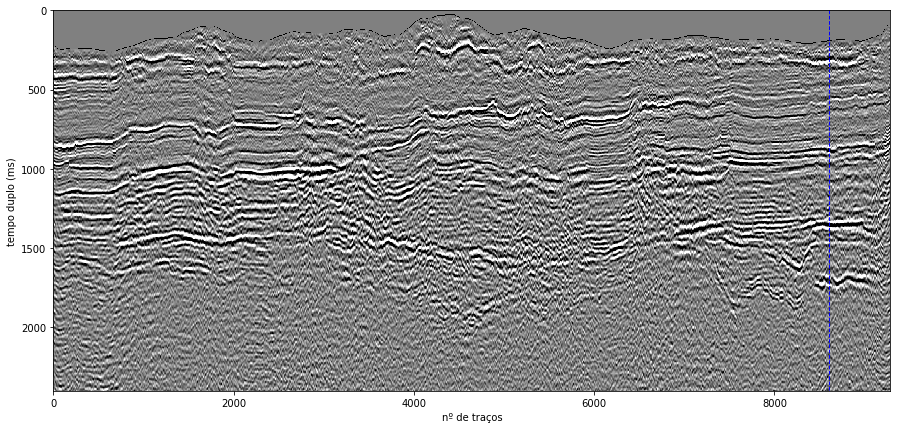

In [30]:
pylab.figure(figsize=(15,7))
pylab.imshow(mtraces[:600,:], aspect='auto', cmap=pylab.cm.gray, origin='upper', vmin=-vmax, vmax=vmax, 
             extent=[0, 9287, 2400., 0.], interpolation='none')
plt.plot([8608, 8608], [0, 2399], '--b', lw=1)
plt.xlabel('nº de traços')
plt.ylabel('tempo duplo (ms)')
#pylab.show()
plt.savefig('resist_parnaiba_2.png', dpi=600)

### Amarrando o Poço

Fizemos um corredor de 10 traços próximos ao traço central para analisar o sintético.

#### Slice do .segy

**namostras:** quantidade de amostras em tempo no dado sísmico  
**t_central:** traço central, sobre o qual será posicionado o perfil sintético  
**t_laterais:** quantidade de traços desejados nas laterais do traço central

In [31]:
namostras=300
t_central=8608
t_laterais=300
traces_slice=mtraces[:namostras,t_central-t_laterais:t_central+t_laterais+1]

#### Cálculo do Time Shift

+ Correção com relação ao datum final de processamento da sísmica. Os valores estão baseados no relatório da sísmica, que diz que o datum de processamento é 600m e a velocidade de substituição é 3000m/s. A elevação do poço foi retirada do pdf do Perfil Composto.  
**d_proc:** datum de processamento  
**elev:** elevação do poço  
**x1:** distância calculada em metros entre o datum de processamento e o topo do poço  
**v1:** velocida de substituição para a distância x1  

+ Correção com relação à falta de dados do poço:  
**x2:** distância em metros entre o início da perfilagem e o topo do poço  
**v2:** velocidade estimada de substituição para a distância x2  

In [32]:
d_proc=600.0
elev=260.0

x2=10.0
v2=2000.0
x1=d_proc-elev 
v1=3000.0

time_shift=2*((x2/v2)+(x1/v1)) #cálculo time shift

#### Plotando o slice do .segy com o sintético por cima

**traces_slice:** slice do segy  
**vmin, vmax:** ajeita a escala de cores  
**extent:** serve para ajustar a escala da imagem. Neste caso, a escala está sendo ajustada para coincidir com a escala de tempo, na vertical, e traços na horizontal. (20 traços para cada lado do sintético e o tempo variando de 0 a 2400ms)

+ No comando "pylab.plot" plotamos o sintético com um shift de 10 traços para a direita (10+synth) e com o time_shift calculado acima (multiplicado por 1000ms para conversão de segundos em milissegundos)
+ Para plotar as soleiras precisamos dar o mesmo time_shift para que elas ficassem posicionadas nos locais corretos com relação ao sintético


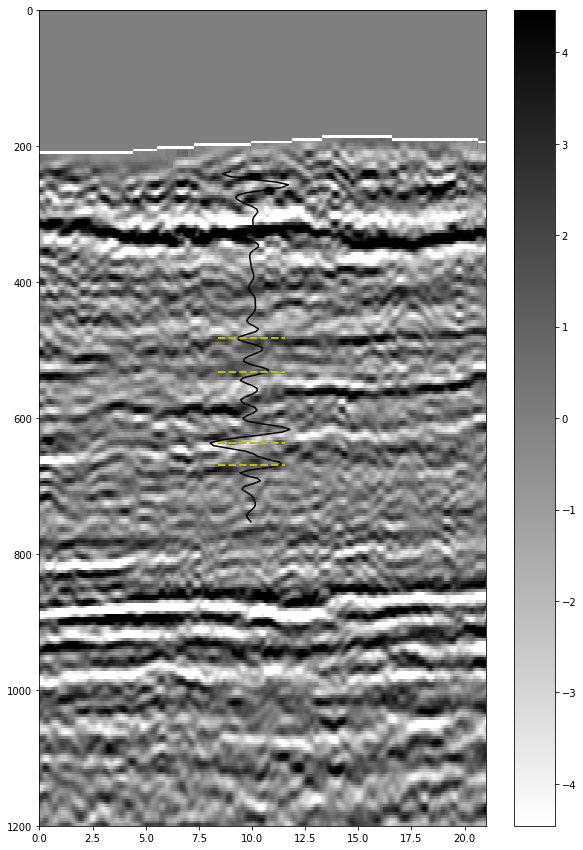

In [33]:
pylab.figure(figsize=(10,15))

pylab.imshow(traces_slice, aspect='auto', cmap=pylab.cm.gray_r, origin='upper', vmin=-vmax, vmax=vmax, 
             extent=[0, 21, namostras*4., 0.])
pylab.plot(10+synth*7, time_shift*1000+np.array(range(synth.size))*4, c='k')
plt.colorbar()
for i in range(len(soleiras)):
    plt.axhline(y = time_shift*1000+soleiras[i]*1000, xmin = 0.4, xmax = 0.55, c='y', lw=2, ls='--')

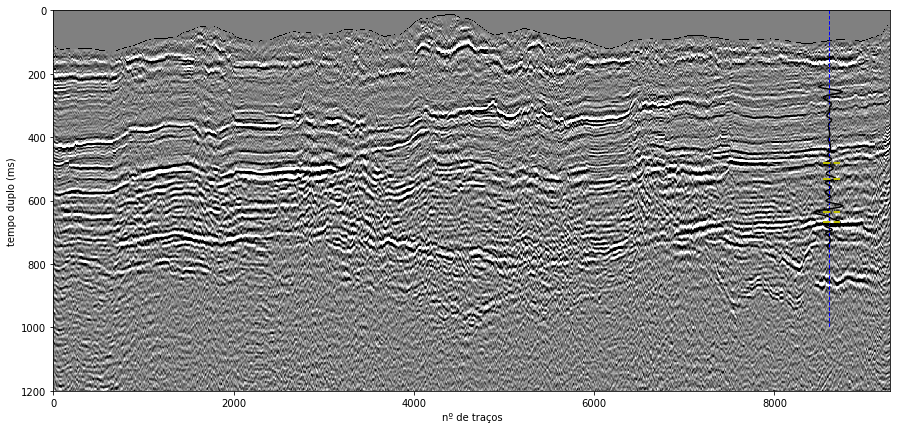

In [46]:
pylab.figure(figsize=(15,7))
pylab.imshow(mtraces[:600,:], aspect='auto', cmap=pylab.cm.gray, origin='upper', vmin=-vmax, vmax=vmax, 
             extent=[0, 9287, namostras*4., 0.], interpolation='none')
plt.plot([8608, 8608], [0, 1000], '--b', lw=1)
pylab.plot(8608+synth*600, time_shift*1000+np.array(range(synth.size))*4, c='k')
for i in range(len(soleiras)):
    plt.axhline(y = time_shift*1000+soleiras[i]*1000, xmin = 0.92, xmax = 0.94, lw=2,  c='y', ls='--')
plt.xlabel('nº de traços')
plt.ylabel('tempo duplo (ms)')
#pylab.show()
plt.savefig('resist_parnaiba_2.png', dpi=600)

## Discussão dos Resultados e Conclusões

#### Analisando as velocidades das soleiras a partir do sintético

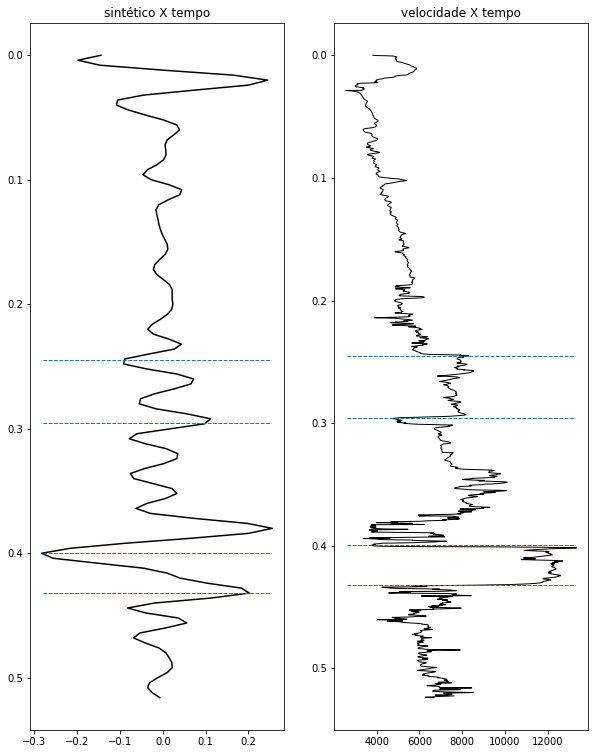

In [35]:
pylab.figure(figsize=(10,13))

pylab.subplot(1,2,1)
pylab.plot(synth, tfr[:-1], c='k')
plt.title('sintético X tempo')
for i in range(len(soleiras)):
    plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
plt.gca().invert_yaxis()

pylab.subplot(1,2,2)
pylab.plot(velocidade, tempo, c='k', lw=1)
plt.title('velocidade X tempo')
for i in range(len(soleiras)):
    plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
plt.gca().invert_yaxis()

pylab.show()

In [36]:
v_sol1=(785-590)*2/(s1_b-s1_t)
v_sol2=(1350-1160)*2/(s2_b-s2_t)
print('v. média soleira 1:', v_sol1,'m/s',',', 'v. média soleira 2:', v_sol2,'m/s')

v. média soleira 1: 7687.55498574 m/s , v. média soleira 2: 11667.2304712 m/s


### Envelope

In [37]:
from scipy.signal import hilbert

In [39]:
envelope = np.abs(hilbert(mtraces, axis=0))

In [40]:
vmax_h = np.percentile(envelope.ravel(), 99.0)
vmin_h = np.percentile(envelope.ravel(), 1.0)

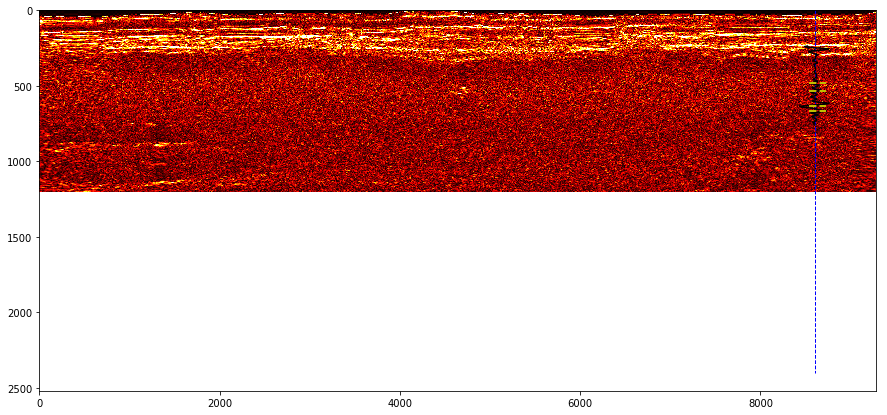

In [45]:
pylab.figure(figsize=(15,7))

plt.imshow(envelope[:800,:], aspect='auto', cmap='hot', vmin=vmin_h, vmax=vmax_h, extent=[0, 9287, namostras*4., 0.])
plt.plot([8608, 8608], [0, 2399], '--b', lw=1)
pylab.plot(8608+synth*600, time_shift*1000+np.array(range(synth.size))*4, c='k')
for i in range(len(soleiras)):
    plt.axhline(y = time_shift*1000+soleiras[i]*1000, xmin = 0.92, xmax = 0.94, lw=2,  c='y', ls='--')

In [42]:
envelope_slice=envelope[:namostras,t_central-t_laterais:t_central+t_laterais+1]

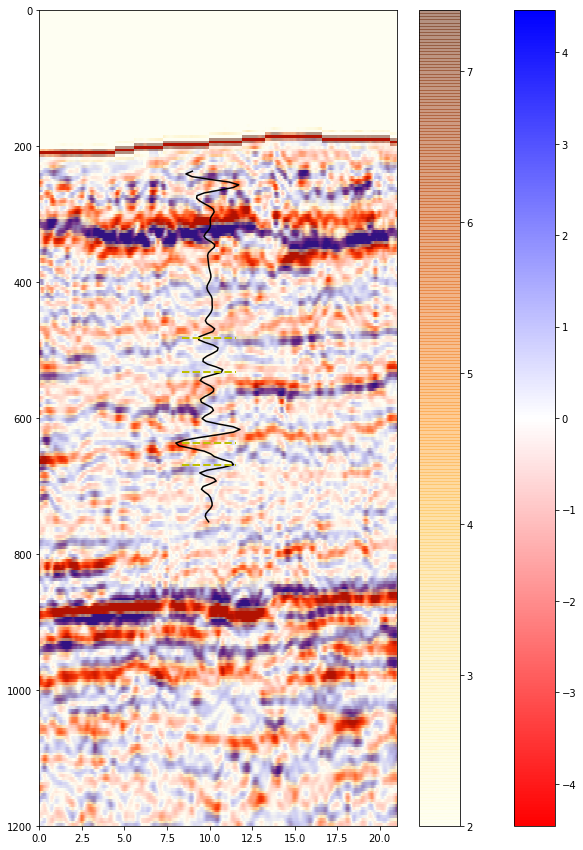

In [43]:
pylab.figure(figsize=(10,15))

pylab.imshow(traces_slice, aspect='auto', cmap='bwr_r', origin='upper', vmin=-vmax, vmax=vmax, 
             extent=[0, 21, namostras*4., 0.])
plt.colorbar()
pylab.imshow(envelope_slice, aspect='auto', cmap='YlOrBr', origin='upper', vmin=2, vmax=vmax_h, 
             extent=[0, 21, namostras*4., 0.], alpha=0.5)
pylab.plot(10+synth*7, time_shift*1000+np.array(range(synth.size))*4, c='k')
plt.colorbar()
for i in range(len(soleiras)):
    plt.axhline(y = time_shift*1000+soleiras[i]*1000, xmin = 0.4, xmax = 0.55, c='y', lw=2, ls='--')